# Análisis de archivos XSLX con Python
Fechao: 16/08/202

Este proyecto analiza datos de acciones almacenados en archivos Excel, utilizando técnicas avanzadas de regresión para obtener perspectivas predictivas.
3

### Importación de Bibliotecas
Primero, vamos a importar las bibliotecas y paquetes que necesitamos para el análisis de datos y la construcción del modelo. Además, definiremos algunas constantes que se usarán más adelante Cambie el valor de EXCEL_FILE_NAME con el archivo de trabajo.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn import svm, model_selection

# Constantes
EXCEL_FILE_NAME = 'Base2.xlsx'
COLUMN_NAMES = {
    "price": "Precio",
    "features": ['Movilveintiuno', 'Movilcincocinco', 'Movilunocuatrocuatro', 'Momentdiez', 'Momentsetenta', 'Momenttrescerocero'],
    "detail": 'Detalle',
}

class SheetResult:
    def __init__(self, sheet_name, final_value):
        self.sheet_name = sheet_name
        self.final_value = final_value
        
    def __str__(self):
        return f"Hoja: {self.sheet_name}, Valor final: {self.final_value}"

print("Librerías y paquetes cargados.")

Librer￭as y paquetes cargados.


### Carga de Datos

La función `load_data  carga los datos desde un archivo Excel. Esta función también maneja posibles errores al intentar abrir el archivo


In [2]:
def load_data(file_name=EXCEL_FILE_NAME):
    try:
        xls = pd.ExcelFile(file_name, engine='openpyxl')
    except FileNotFoundError:
        return None, f"🚨 [ERROR]: El archivo '{file_name}' no fue encontrado. Por favor comprueba la ubicación (path) y el nombre del archivo."
    except Exception as e:
        return None, f"🚨 [ERROR]: No se puede abrir el archivo '{file_name}'. Error: {str(e)}"

    all_sheets = {}
    for sheet_name in xls.sheet_names:
        sheet_data = pd.read_excel(xls, sheet_name, index_col='FECHA')
        if not sheet_data.empty:
            all_sheets[sheet_name] = sheet_data
    return all_sheets, "Data cargada correctamente"

all_data, message = load_data()

first_sheet_name = list(all_data.keys())[0]
print(f"\nSample de la data de la primera hoja: {first_sheet_name}")
display(all_data[first_sheet_name].head())


Sample de la data de la primera hoja: Diario


,Precio,Movilveintiuno,Movilcincocinco,Movilunocuatrocuatro,Momentdiez,Momentsetenta,Momenttrescerocero,Detalle,Variaci￳n
FECHA,,,,,,,,,
2008-11-07,3.509,3.611524,4.417364,5.540576,106.688963,62.716711,68.149155,1.0,0.024825
2008-11-10,3.424,3.609952,4.364818,5.526035,95.964126,62.573099,70.106470,1.0,0.011521
2008-11-11,3.385,3.583619,4.314309,5.509604,90.653455,59.002963,70.199088,1.0,0.051569
2008-11-12,3.219,3.559905,4.260091,5.490250,81.164902,54.894270,68.402040,0.0,-0.065331
2008-11-13,3.444,3.557333,4.209291,5.474438,89.617486,58.952414,70.530412,1.0,0.068570


### Preprocesamiento de Datos

Antes de entrenar nuestro modelo, es necesario preprocesar los datos. Esta etapa incluye convertir columnas a formato numérico y normalizarlas.

In [3]:
def preprocess_data(df):
    columns_to_check = [COLUMN_NAMES["price"], COLUMN_NAMES["detail"]] + COLUMN_NAMES["features"]
    for column in columns_to_check:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    df.fillna(method='ffill', inplace=True)
    
    # Normalizar la data
    columns_to_normalize = [COLUMN_NAMES["price"]] + COLUMN_NAMES["features"]
    for column in columns_to_normalize:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

    return df

for sheet_name, df in all_data.items():
    all_data[sheet_name] = preprocess_data(df)

print(f"Muestra de la data preprocesada de la primera hoja: {first_sheet_name}\n")
display(all_data[first_sheet_name].head())

Muestra de la data preprocesada de la primera hoja: Diario



,Precio,Movilveintiuno,Movilcincocinco,Movilunocuatrocuatro,Momentdiez,Momentsetenta,Momenttrescerocero,Detalle,Variaci￳n
FECHA,,,,,,,,,
2008-11-07,0.003995,0.002878,0.007102,0.012798,0.632566,0.143085,0.100679,1.0,0.024825
2008-11-10,0.003521,0.002869,0.006791,0.012708,0.390756,0.141932,0.108098,1.0,0.011521
2008-11-11,0.003303,0.002717,0.006492,0.012606,0.271018,0.113270,0.108449,1.0,0.051569
2008-11-12,0.002377,0.002580,0.006170,0.012486,0.057081,0.080285,0.101638,0.0,-0.065331
2008-11-13,0.003632,0.002565,0.005869,0.012388,0.247660,0.112864,0.109705,1.0,0.068570


### Entrenamiento del Modelo

Una vez que los datos están preprocesados, podemos entrenar nuestro modelo de regresión usandoel MLP Regressor.


In [4]:
def train_model(df):
    feature_cols = COLUMN_NAMES["features"]

    datos_entrenamiento = df.iloc[0:2886, 0:9]
    datos_prueba = df.iloc[2887:3607, 0:9]

    X_train = datos_entrenamiento[feature_cols].values
    Y_train = datos_entrenamiento['Detalle'].values.astype('float')
    X_test = datos_prueba[feature_cols].values
    Y_test = datos_prueba['Detalle'].values.astype('float')

    # Entrenar el MLP Regressor
    modelo_red_neuronal = MLPRegressor(activation='logistic', hidden_layer_sizes=(200), max_iter=1000, solver='adam')
    modelo_red_neuronal.fit(X_train, Y_train)
    
    return modelo_red_neuronal, X_test, Y_test

trained_models = {}
for sheet_name, df in all_data.items():
    model, X_test, Y_test = train_model(df)
    trained_models[sheet_name] = (model, X_test, Y_test)

print("Modelos entrenados para todas las hojas.")

print(f"\nEjemplo del X_test de la primera hoja: {first_sheet_name}")
pd.DataFrame(trained_models[first_sheet_name][1]).head()

Modelos entrenados para todas las hojas.

Ejemplo del X_test de la primera hoja: Diario


,0,1,2,3,4,5
0,0.375469,0.389512,0.406778,0.569451,0.382006,0.486161
1,0.378781,0.388485,0.407447,0.580591,0.366553,0.471220
2,0.382099,0.387631,0.408159,0.690004,0.378965,0.479747
3,0.385961,0.386893,0.408947,0.656998,0.412798,0.487316
4,0.388585,0.386399,0.409740,0.691617,0.399290,0.500447


### Evaluación del Modelo

Con los modelos entrenados, podemos evaluar su rendimiento y determinar elthresholdl óptimo para la clasificación


In [5]:
def evaluate_model(model, X_test, Y_test):
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({
        'fpr': pd.Series(fpr, index=i), 
        'tpr': pd.Series(tpr, index=i), 
        '1-fpr': pd.Series(1-fpr, index=i), 
        'tf': pd.Series(tpr - (1-fpr), index=i), 
        'thresholds': pd.Series(thresholds, index=i)
    })
    optimal_threshold = roc.iloc[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]

    conteo_positivos_reales  = np.sum(Y_test)
    df_predicciones = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred})
    df_predicciones['threshold_comparison'] = (df_predicciones['Predicted'] > optimal_threshold).astype(int)
    conteo_positivos_predichos = df_predicciones['threshold_comparison'].sum()

    final_value = conteo_positivos_reales - conteo_positivos_predichos
    return final_value, df_predicciones, optimal_threshold, conteo_positivos_reales, conteo_positivos_predichos

results = []
sample_df_temp = None
for sheet_name, (model, X_test, Y_test) in trained_models.items():
    final_value, df_temp, optimal_threshold, conteo_positivos_reales, conteo_positivos_predichos = evaluate_model(model, X_test, Y_test)
    results.append(SheetResult(sheet_name, final_value))
    if sample_df_temp is None:
        sample_df_temp = df_temp
        sample_threshold = optimal_threshold

print(f"Solo mostraremos una hoja de ejemplo para su análisis.")
print(f"El threshold de esta hoja es: {sample_threshold}\n")
print(f"conteo_positivos_reales: {conteo_positivos_reales}")
print(f"conteo_positivos_predichos: {conteo_positivos_predichos}")
sample_df_temp

Solo mostraremos una hoja de ejemplo para su análisis.
El threshold de esta hoja es: 0.532415726146514

conteo_positivos_reales: 341.0
conteo_positivos_predichos: 358


,Actual,Predicted,threshold_comparison
0,1.0,0.499572,0
1,0.0,0.499169,0
2,0.0,0.497587,0
3,0.0,0.498189,0
4,0.0,0.497958,0
...,...,...,...
715,0.0,0.531936,0
716,1.0,0.530399,0
717,0.0,0.530859,0
718,1.0,0.530732,0


Nota: en la celda anterior se pueden ver muchos valores con 0. Estos valores tienden a estar en una zona particular de la data. Para ello, vamos a guardar toda la data de esta hoja de ejemplo en un archivo txt.

In [6]:
sample_df_temp.to_csv('sample_df_temp.txt', sep='\t', index=False)
print(f"¡El archivo se ha guardado exitosamente!")

¡El archivo se ha guardado exitosamente!


#### Evaluación manual

Quizá sea relevante saber en qué parte de nuestra lista se ha logrado obtener datos positivos (es decir, de 1). Estos se pueden ver en la gráfica a continuación.

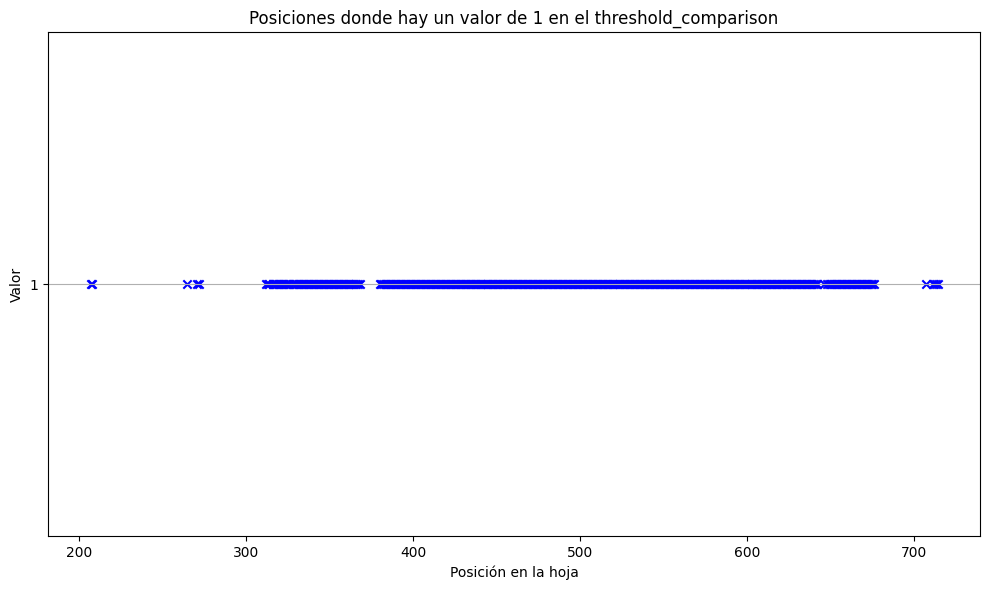

In [7]:
subset_df = sample_df_temp[sample_df_temp['threshold_comparison'] == 1]

plt.figure(figsize=(10,6))
plt.scatter(subset_df.index, subset_df['threshold_comparison'], c='blue', marker='x')
plt.title('Posiciones donde hay un valor de 1 en el threshold_comparison')
plt.xlabel('Posición en la hoja')
plt.ylabel('Valor')
plt.yticks([1])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Resultados

Creemos undfe para visualizar los resultados decada hoja.


In [8]:
data = [{'sheet_name': result.sheet_name, 'final_value': result.final_value} for result in results]
df_results = pd.DataFrame(data)
df_results.head()

,sheet_name,final_value
0,Diario,-17.0
1,Diario 2,-17.0
2,Diario 3,-17.0
3,Diario 4,-18.0
4,Diario 5,-18.0


### Ordenamiento de Resultados

Ordenaremos los resultados en función del valor final. De mayor a menor. Para poder obtener los primeros 10 o últimos 10, es decir, los mejores y peores.

In [9]:
sorted_results = sorted(results, key=lambda x: x.final_value, reverse=True)

### Las 10 mejores hojas


In [10]:
print("Las 10 mejores 📈:")
best_10 = [(r.sheet_name, r.final_value) for r in sorted_results[:10]]
pd.DataFrame(best_10, columns=['Sheet Name', 'Value'])

Las 10 mejores 📈:


,Sheet Name,Value
0,Diario 17,-15.0
1,Diario 11,-16.0
2,Diario 13,-16.0
3,Diario 15,-16.0
4,Diario 18,-16.0
5,Diario 19,-16.0
6,Diario 20,-16.0
7,Diario,-17.0
8,Diario 2,-17.0
9,Diario 3,-17.0


### Las 10 peores hojas

In [11]:
print("\nLas 10 peores 📉:")
worst_10 = [(r.sheet_name, r.final_value) for r in sorted_results[-10:]]
pd.DataFrame(worst_10, columns=['Sheet Name', 'Value'])


Las 10 peores 📉:


,Sheet Name,Value
0,Diario 12,-17.0
1,Diario 14,-17.0
2,Diario 16,-17.0
3,Diario 21,-17.0
4,Diario 22,-17.0
5,Diario 23,-17.0
6,Diario 4,-18.0
7,Diario 5,-18.0
8,Diario 6,-18.0
9,Diario 10,-20.0
